# Exploratory Data Analysis

In [ ]:
#system modules
import os
import itertools
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#pre-processing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#deep learning modules
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam, Adamax


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# test set
## Get paths of the test directory
Training = "/content/drive/MyDrive/Colab Notebooks/test (1)"
imgpaths = []
labels = []
tr_dir = os.listdir(Training)  # Get list of directories in Training directory

## Iterate through directories in test directory
for i in tr_dir:
    classpath = os.path.join(Training, i)
    # Check if the path is a directory
    if os.path.isdir(classpath):
        imglist = os.listdir(classpath)
        # Iterate through files in the directory
        for img in imglist:
            # Filter out unwanted files like .DS_Store
            if not img.startswith('.'):
                imgpath = os.path.join(classpath, img)
                imgpaths.append(imgpath)
                labels.append(i)

## Create the data frame
Paths = pd.Series(imgpaths, name='Paths')
Labels = pd.Series(labels, name='Labels')
Tr_data = pd.concat([Paths, Labels], axis=1)


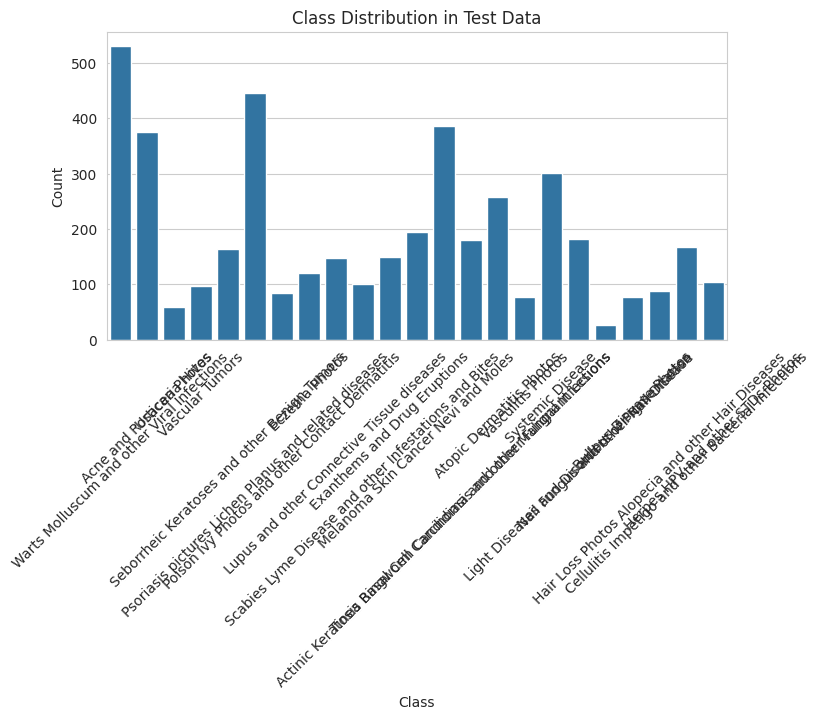

In [ ]:
# Class Distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='Labels', data=Tr_data)
plt.title('Class Distribution in Test Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Sample Images from specified classes
specified_classes = ['Acne and Rosacea Photos', 'Light Diseases and Disorders of Pigmentation', 'Melanoma Skin Cancer Nevi and Moles']


In [ ]:
Tr_data.head()

,Paths,Labels
0,/content/drive/MyDrive/Colab Notebooks/test (1...,Warts Molluscum and other Viral Infections
1,/content/drive/MyDrive/Colab Notebooks/test (1...,Warts Molluscum and other Viral Infections
2,/content/drive/MyDrive/Colab Notebooks/test (1...,Warts Molluscum and other Viral Infections
3,/content/drive/MyDrive/Colab Notebooks/test (1...,Warts Molluscum and other Viral Infections
4,/content/drive/MyDrive/Colab Notebooks/test (1...,Warts Molluscum and other Viral Infections


In [ ]:
Tr_data.describe()

,Paths,Labels
count,4317,4317
unique,4317,23
top,/content/drive/MyDrive/Colab Notebooks/test (1...,Warts Molluscum and other Viral Infections
freq,1,530


In [ ]:
Tr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4317 entries, 0 to 4316
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Paths   4317 non-null   object
 1   Labels  4317 non-null   object
dtypes: object(2)
memory usage: 67.6+ KB


We separate 3 classes from our dataset namely 'Acne and Rosacea Photos', 'Light Diseases and Disorders of Pigmentation', and 'Melanoma Skin Cancer Nevi and Moles' to make our prediction more robust and proper. After analysing the data, these samples were chosen because they had the best class representation. Furthermore, due to imbalance in the dataset, pertaining to the quality of the images and the fact that the images cover different portions of the body, it reduced the accuracy of our model. The given classes had a clear pigmentation, and could be trained easily.

The specificed classes were chosen for robust accuracy of our model

# Displaying Sample Images from Specified Classes


We filter the DataFrame Tr_data to select images from specified classes (specified_classes). It then iterates through each specified class, prints the class name, and displays three sample images from that class. The images are shown using subplots, with each row representing a different class and each column displaying a sample image. The code utilizes Matplotlib to visualize the images.

Class: Acne and Rosacea Photos
Class: Light Diseases and Disorders of Pigmentation
Class: Melanoma Skin Cancer Nevi and Moles


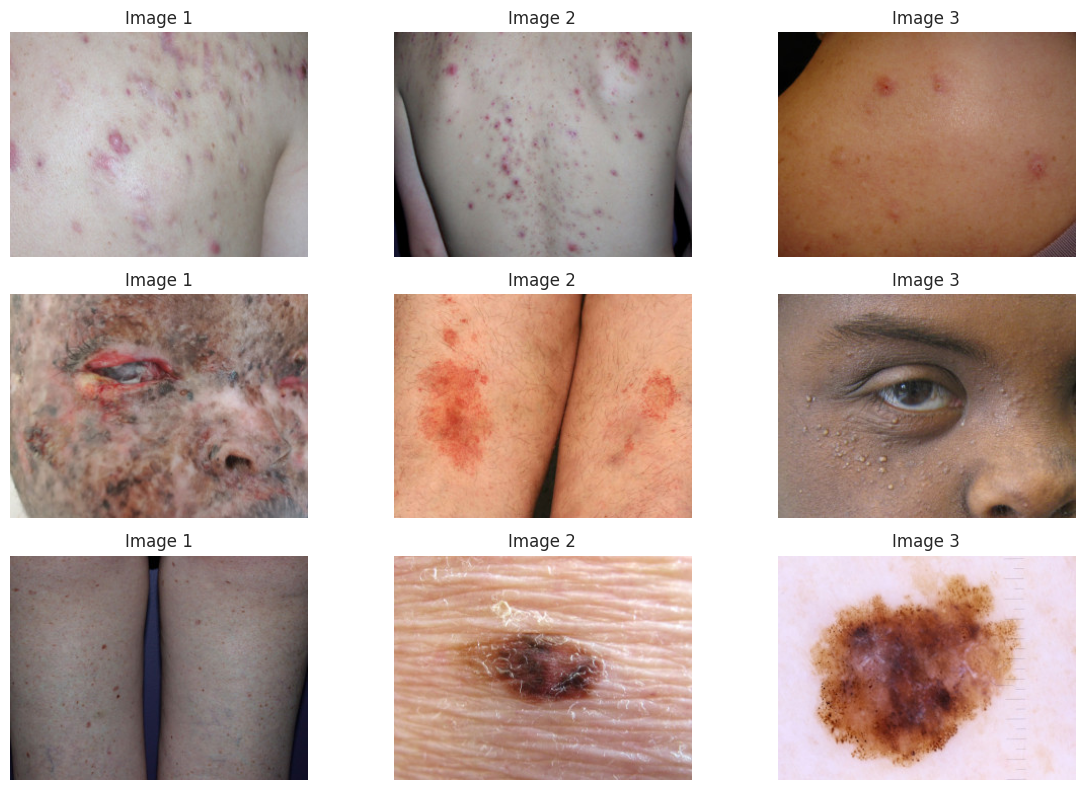

In [ ]:
# Filter the DataFrame to select images from specified classes
specified_data = Tr_data[Tr_data['Labels'].isin(specified_classes)]

# Initialize subplot for displaying images
plt.figure(figsize=(12, 8))

# Counter for subplots
plot_num = 1

# Iterate through each specified class
for class_name in specified_classes:
    # Filter data for the current class
    class_data = specified_data[specified_data['Labels'] == class_name]

    # Print class name
    print(f"Class: {class_name}")

    # Counter for images printed
    image_count = 0

    # Iterate through images in the current class
    for index, row in class_data.iterrows():
        # Load and display the image
        img = Image.open(row['Paths'])
        plt.subplot(len(specified_classes), 3, plot_num)
        plt.imshow(img)
        plt.title(f"Image {image_count + 1}")
        plt.axis('off')
        plot_num += 1
        image_count += 1

        # If three images have been printed, break the loop
        if image_count == 3:
            break

# Show the plots
plt.tight_layout()
plt.show()


# Calculating Mean and Standard Deviation of Pixel Values


Calculating the mean and standard deviation of pixel values from images in the specified classes. We do this by iterating through each specified class, loading up to 100 images from that class, calculating the mean and standard deviation of pixel values for each image, and then appending these values to separate lists. Finally, we calculate the overall mean and standard deviation of pixel values across all images from the specified classes and print them. The code utilizes the PIL library to load images and NumPy for numerical computations.

In [ ]:
# Initialize lists to store pixel values
pixel_values_mean = []
pixel_values_std = []

#we take 10 values only because of the limitations imposed by the hardware

# Iterate through each specified class
for class_name in specified_classes:
    # Filter data for the current class
    class_data = specified_data[specified_data['Labels'] == class_name]

    # Iterate through images in the current class (up to 3 images)
    for index, row in class_data.head(100).iterrows():
        # Load the image
        img = Image.open(row['Paths'])

        # Convert the image to grayscale if it's a colored image
        if img.mode != 'L':
            img = img.convert('L')

        # Convert image to numpy array
        img_array = np.array(img)

        # Calculate mean and standard deviation of pixel values
        mean_val = np.mean(img_array)
        std_val = np.std(img_array)

        # Append mean and standard deviation to the lists
        pixel_values_mean.append(mean_val)
        pixel_values_std.append(std_val)

# Calculate overall mean and standard deviation
overall_mean = np.mean(pixel_values_mean)
overall_std = np.mean(pixel_values_std)

print("Overall Mean of Pixel Values:", overall_mean)
print("Overall Standard Deviation of Pixel Values:", overall_std)


Overall Mean of Pixel Values: 134.89185287328147
Overall Standard Deviation of Pixel Values: 37.83088909177029


The standard deviation for each image is high, therefore it indicates that the pixel values are spread out and have relatively high variance.



# Label Distribution for specified classes

We create a bar plot to visualize the label distribution for the specified classes. We start by creating a dictionary to count the number of images in each specified class, initializing the counts to zero for each class. Then, iterating through all labels in the dataset and increments the count for each specified class label encountered. Finally, plotting the bar chart using Matplotlib, with class labels on the x-axis and the number of images on the y-axis, providing a visual representation of the distribution of images across the specified classes.

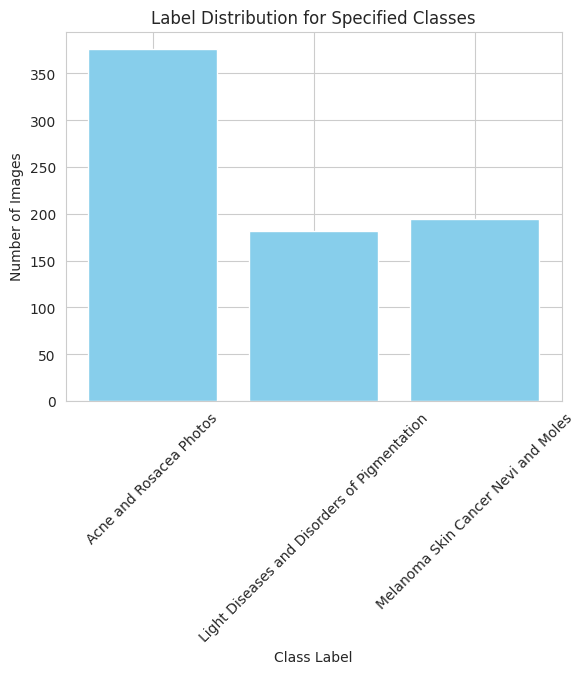

In [ ]:
# Create a list of the specified class labels
specified_class_labels = specified_classes

# Create a dictionary to count the number of images in each specified class
specified_label_counts = {class_label: 0 for class_label in specified_class_labels}
for lbl in Labels:
    if lbl in specified_class_labels:
        specified_label_counts[lbl] += 1

# Create a bar chart to visualize the label distribution for the specified classes
plt.bar(range(len(specified_label_counts)), list(specified_label_counts.values()), align='center', color='skyblue')
plt.xticks(range(len(specified_label_counts)), list(specified_label_counts.keys()), rotation=45)
plt.title('Label Distribution for Specified Classes')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.show()


# Analyzing Color Distribution of Specified Classes


We analze the color distribution of images belonging to the specified classes. The code below iterates through each image in the dataset and considers up to 30 images per class due to hardware limitations. For each image, it loads the image, converts it to RGB mode, and extracts the RGB pixel values. It then appends these RGB pixel values to separate lists for red, green, and blue channels. Finally, it creates histograms for each color channel using Matplotlib, providing a visual representation of the color distribution across the specified classes.

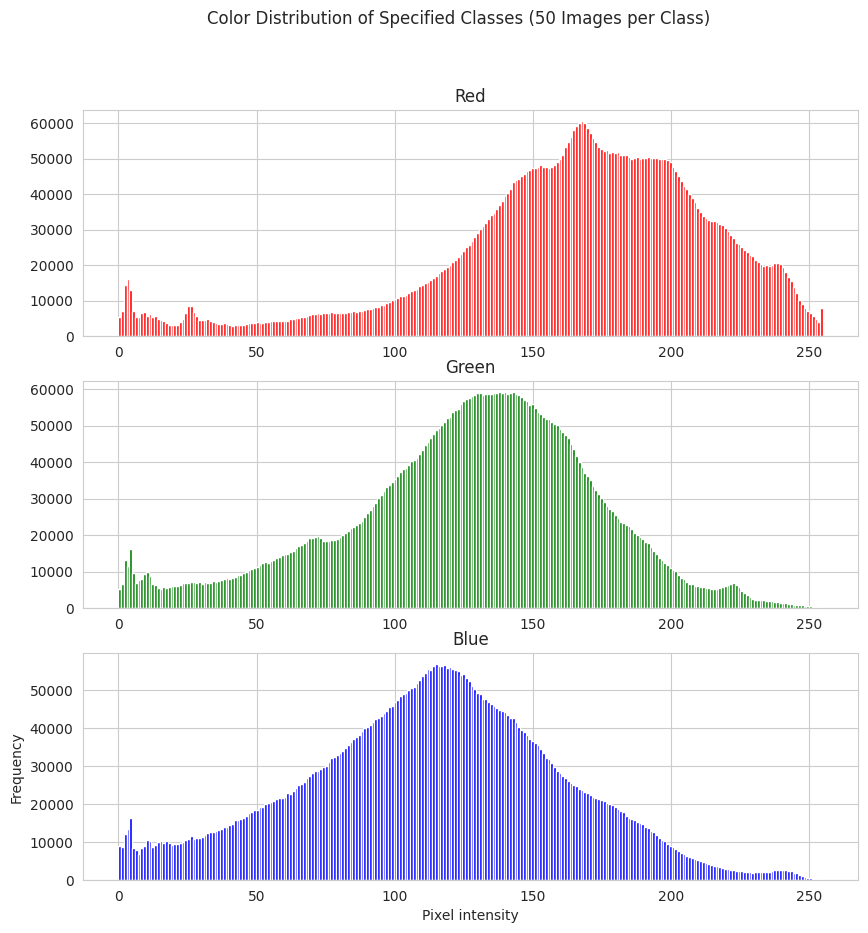

In [ ]:
# Initialize lists to store RGB pixel values for the specified classes
specified_r = []
specified_g = []
specified_b = []
image_count_per_class = 30  # Number of images to consider per class because of the limitations imposed by the hardware

# Counter to keep track of the number of images processed for each class
processed_images_per_class = {class_label: 0 for class_label in specified_classes}

# Iterate through each image in the specified classes
for index, row in Tr_data.iterrows():
    if row['Labels'] in specified_classes and processed_images_per_class[row['Labels']] < image_count_per_class:
        # Load the image
        img = Image.open(row['Paths'])

        # Convert the image to RGB mode
        img = img.convert('RGB')

        # Extract RGB pixel values
        img_array = np.array(img)
        r_values = img_array[:,:,0].ravel()
        g_values = img_array[:,:,1].ravel()
        b_values = img_array[:,:,2].ravel()

        # Append RGB pixel values to lists
        specified_r.append(r_values)
        specified_g.append(g_values)
        specified_b.append(b_values)

        # Increment the counter for the current class
        processed_images_per_class[row['Labels']] += 1

        # Check if we have processed enough images for all specified classes
        if all(count >= image_count_per_class for count in processed_images_per_class.values()):
            break

# Create histograms for each color channel
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].hist(np.concatenate(specified_r), bins=256, color='r')
axs[1].hist(np.concatenate(specified_g), bins=256, color='g')
axs[2].hist(np.concatenate(specified_b), bins=256, color='b')

# Set the title and axis labels
fig.suptitle('Color Distribution of Specified Classes (50 Images per Class)')
axs[0].set_title('Red')
axs[1].set_title('Green')
axs[2].set_title('Blue')
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency')
# Show the plot
plt.show()


# Analyzing Pixel Intensity Distribution of Specified Classes Subset


We explore the pixel intensity distribution of a subset of images belonging to the specified classes. We randomly select 100 images from the specified classes and convert each image to grayscale. Then, flatten the pixel intensities of each image and appends them to a list. Finally, we plot pixel intensities using Matplotlib, providing a visual representation of the distribution of pixel intensities across the subset of images from the specified classes.

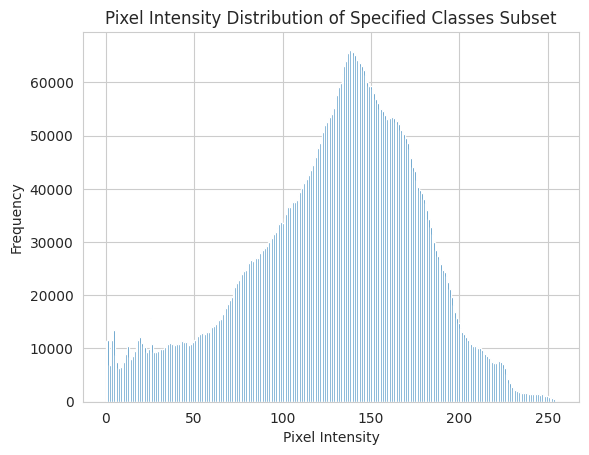

In [ ]:
# Get random subset of 100 images from the specified classes
subset_indices = np.random.choice(len(specified_data), size=100, replace=False)

# Initialize list to store pixel intensities
subset_pixel_intensities = []

# Iterate through the random subset of images
for index in subset_indices:
    # Load the image
    img = Image.open(specified_data.iloc[index]['Paths'])

    # Convert the image to grayscale
    img = img.convert('L')

    # Extract pixel intensities
    img_array = np.array(img).ravel()

    # Append pixel intensities to the list
    subset_pixel_intensities.extend(img_array)

# Plot pixel intensity distribution
plt.hist(subset_pixel_intensities, bins=256, range=(0, 255))
plt.title('Pixel Intensity Distribution of Specified Classes Subset')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


# Analyzing Principal Components of Specified Classes Subset using PCA


Utilising Principal Component Analysis (PCA) to reduce the dimensionality of a subset of images belonging to the specified classes. The code is given below. It randomly selects 100 images from the specified classes, converts each image to grayscale, and flattens the image data. Then, it performs PCA to reduce the dimensionality of the flattened image data to 2 dimensions. It also assigns numerical labels to class names using LabelEncoder. Finally, it plots the results using Matplotlib, with each point representing an image in the reduced 2D space, colored by class label, providing a visualization of the distribution of images from the specified classes in the reduced feature space.

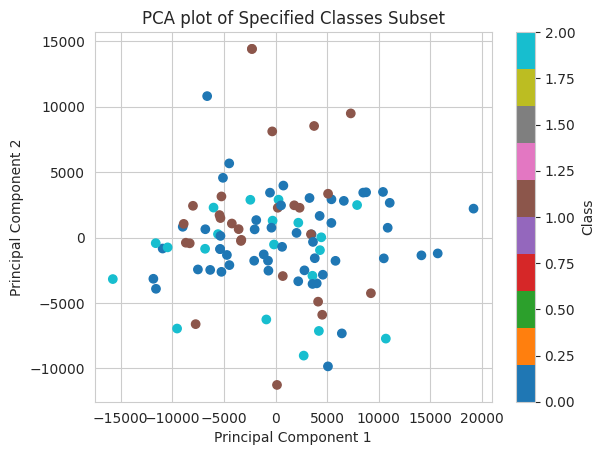

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Get random subset of 100 images from the specified classes
subset_indices = np.random.choice(len(specified_data), size=100, replace=False)

# Initialize list to store flattened image data
subset_data = []

# Iterate through the random subset of images
for index in subset_indices:
    # Load the image
    img = Image.open(specified_data.iloc[index]['Paths'])

    # Convert the image to grayscale
    img = img.convert('L')

    # Flatten the image data
    img_array = np.array(img).flatten()

    # Append the flattened image data to the list
    subset_data.append(img_array)

# Convert the subset data to a numpy array
subset_data = np.array(subset_data)

# Perform PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
subset_data_pca = pca.fit_transform(subset_data)

# Initialize LabelEncoder to assign numerical labels to class names
label_encoder = LabelEncoder()

# Fit LabelEncoder on the specified class labels
label_encoder.fit(specified_data['Labels'])

# Convert class names to numerical labels
numeric_labels = label_encoder.transform(specified_data['Labels'])

# Plot the results with numerical labels
plt.scatter(subset_data_pca[:, 0], subset_data_pca[:, 1], c=numeric_labels[subset_indices], cmap='tab10')
plt.colorbar(label='Class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA plot of Specified Classes Subset')
plt.show()
